#  **Time Series Analysis - California Stores Sales 💰📈📊**


## **1. Business Understanding**

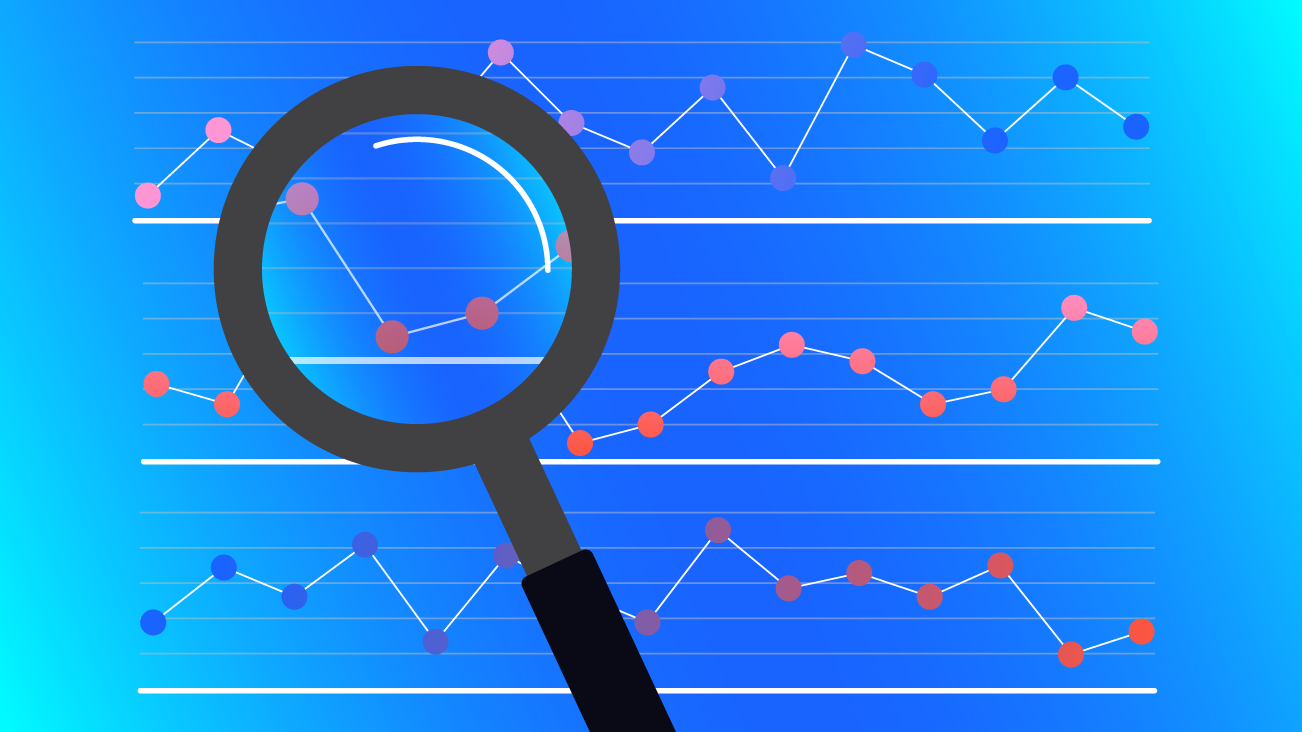

> **Background:**
 In this project, we deal with a multi-state superstore sales dataset. The management thinks that they need to analyze California state sales and forecast for the future as well, as this will help them in making a number of business decisions.

> **Objective:**
1. Collecting and cleaning the sales data.
2. Exploring, decomposing and extracting insights from California sales.
3. Predicting 3-month forward sales for California.  




## **2. Data Understanding**

### 2.1 Importing packages

In [ ]:
!pip install pmdarima
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True, linewidth=100, precision=5)

### 2.2 Collecting Data

In [ ]:
df = pd.read_csv("Superstore.csv")
California = df[df['State']=='California']
California.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620
5,6,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.860
6,7,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.280
7,8,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.152
8,9,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.504


### 2.3 Inspecting Data

In [ ]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check
check(California)

,column,dtypes,nunique,sum_null
0,Row ID,int64,1946,0
1,Order ID,object,1002,0
2,Order Date,object,651,0
3,Ship Date,object,681,0
4,Ship Mode,object,4,0
5,Customer ID,object,570,0
6,Customer Name,object,570,0
7,Segment,object,3,0
8,Country,object,1,0
9,City,object,80,0


## **3. Data Preparation**

### 3.1 Data Cleaning

In [ ]:
# droping unnecessary columns
California = California[['Order Date', 'Sales']]

# renaming the columns to be in lowercase separated by '_' instead of spaces
California.rename( columns= lambda x : x.strip().lower().replace(' ','_'), inplace = True)

# modifying the date column data type
California['order_date'] = pd.to_datetime(California['order_date'])

# sorting data by order dates
California = California.sort_values(by = 'order_date', ascending=True)
California.head()

,order_date,sales
1373,2015-01-04,17.088
1372,2015-01-04,29.600
2172,2015-01-08,19.752
1161,2015-01-09,53.940
5895,2015-01-11,44.400


### 3.2 Data Manipulation

In [ ]:
# indexing the data by order dates
California = California.set_index('order_date')

# resampling the data on a weekly basis and summing the sales
California = California.resample('W').agg({'sales':'sum'})

# viewing the data
California.head()

,sales
order_date,
2015-01-04,46.688
2015-01-11,139.492
2015-01-18,1737.949
2015-01-25,38.660
2015-02-01,717.336


## **4. Exploratory Data Analysis (EDA)**

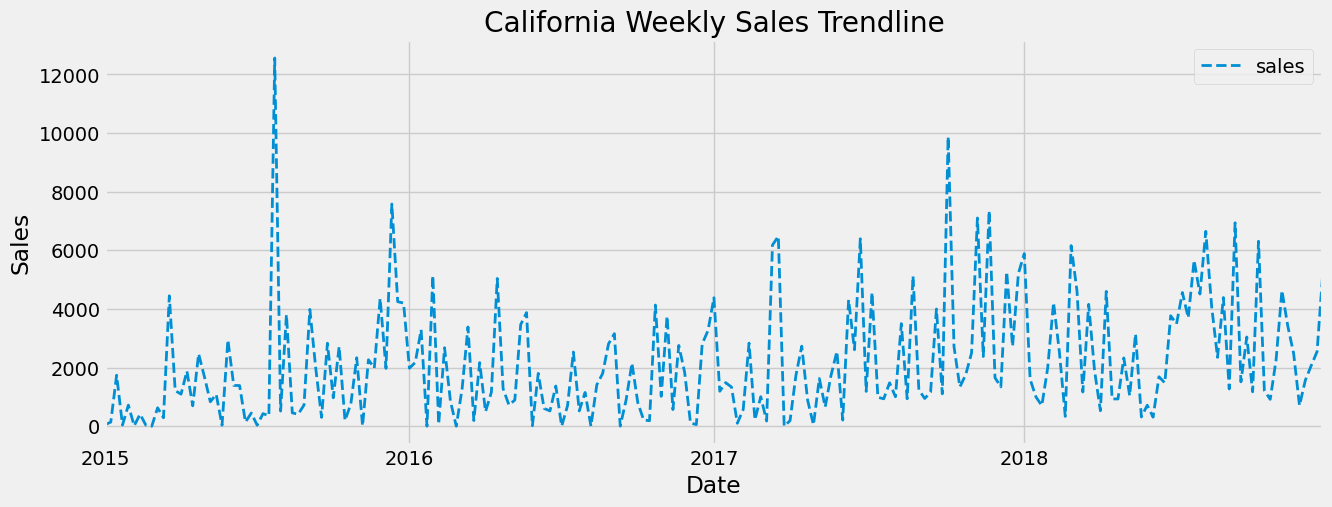

In [ ]:
## Weekly sales Trendline
ax = California.plot(figsize=(14, 5), linestyle='--', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('California Weekly Sales Trendline')
plt.show()

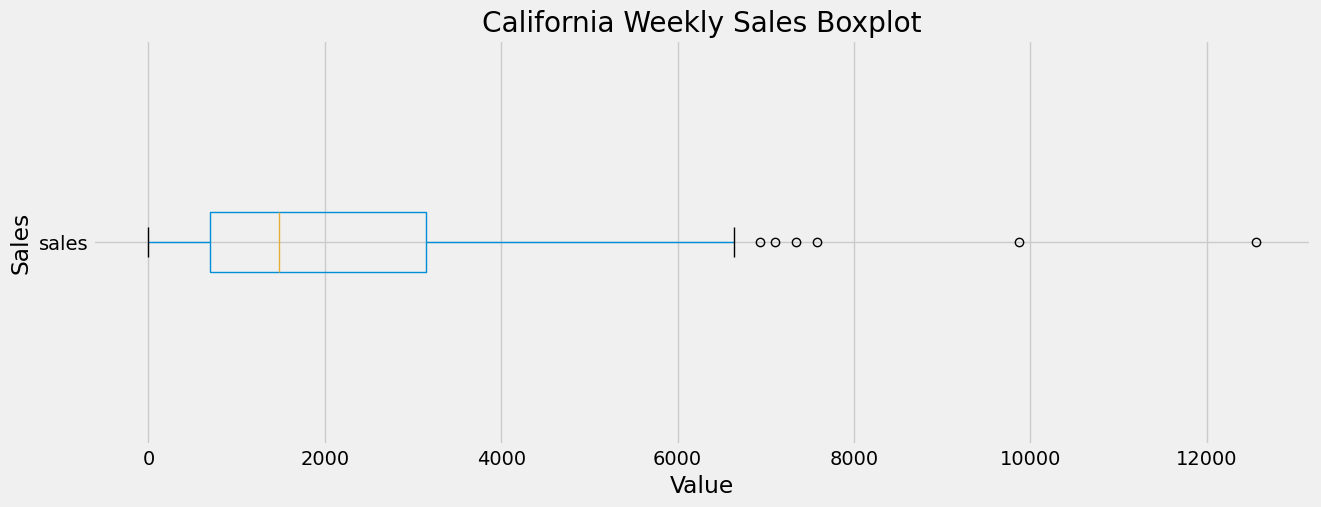

In [ ]:
## Summary Statistics ~ Boxplot
ax = California.boxplot(figsize=(14, 5), vert=False)
ax.set_xlabel('Value')
ax.set_ylabel('Sales')
ax.set_title("California Weekly Sales Boxplot")
plt.show()

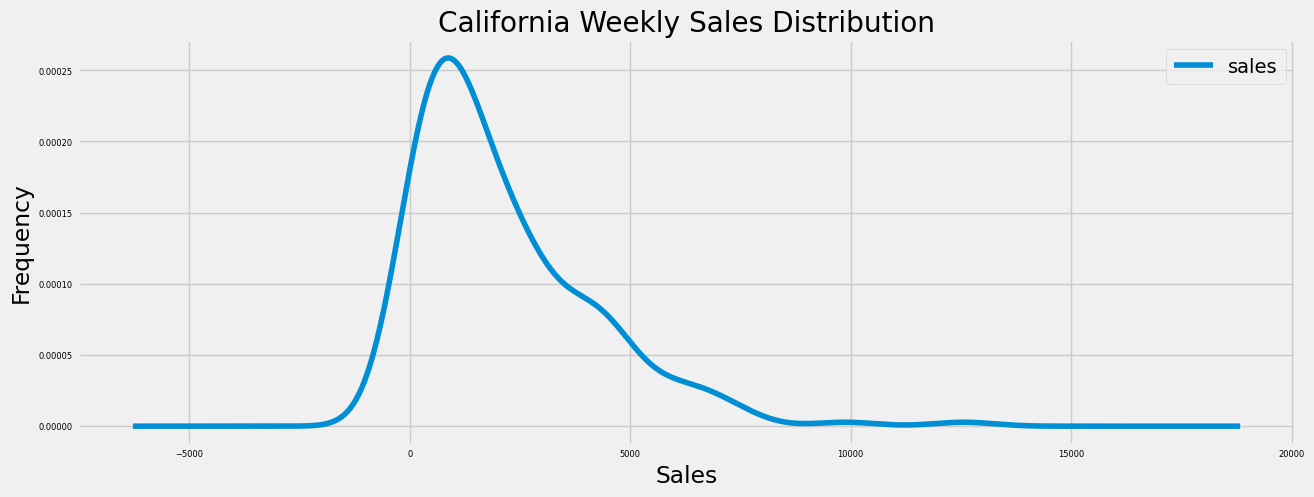

In [ ]:
## California Weekly Sales Distribution ~ Density Plot
ax = California.plot(figsize=(14, 5), kind='density', linewidth=4, fontsize=6)
ax.set_xlabel('Sales')
ax.set_ylabel('Frequency')
ax.set_title('California Weekly Sales Distribution')
plt.show()

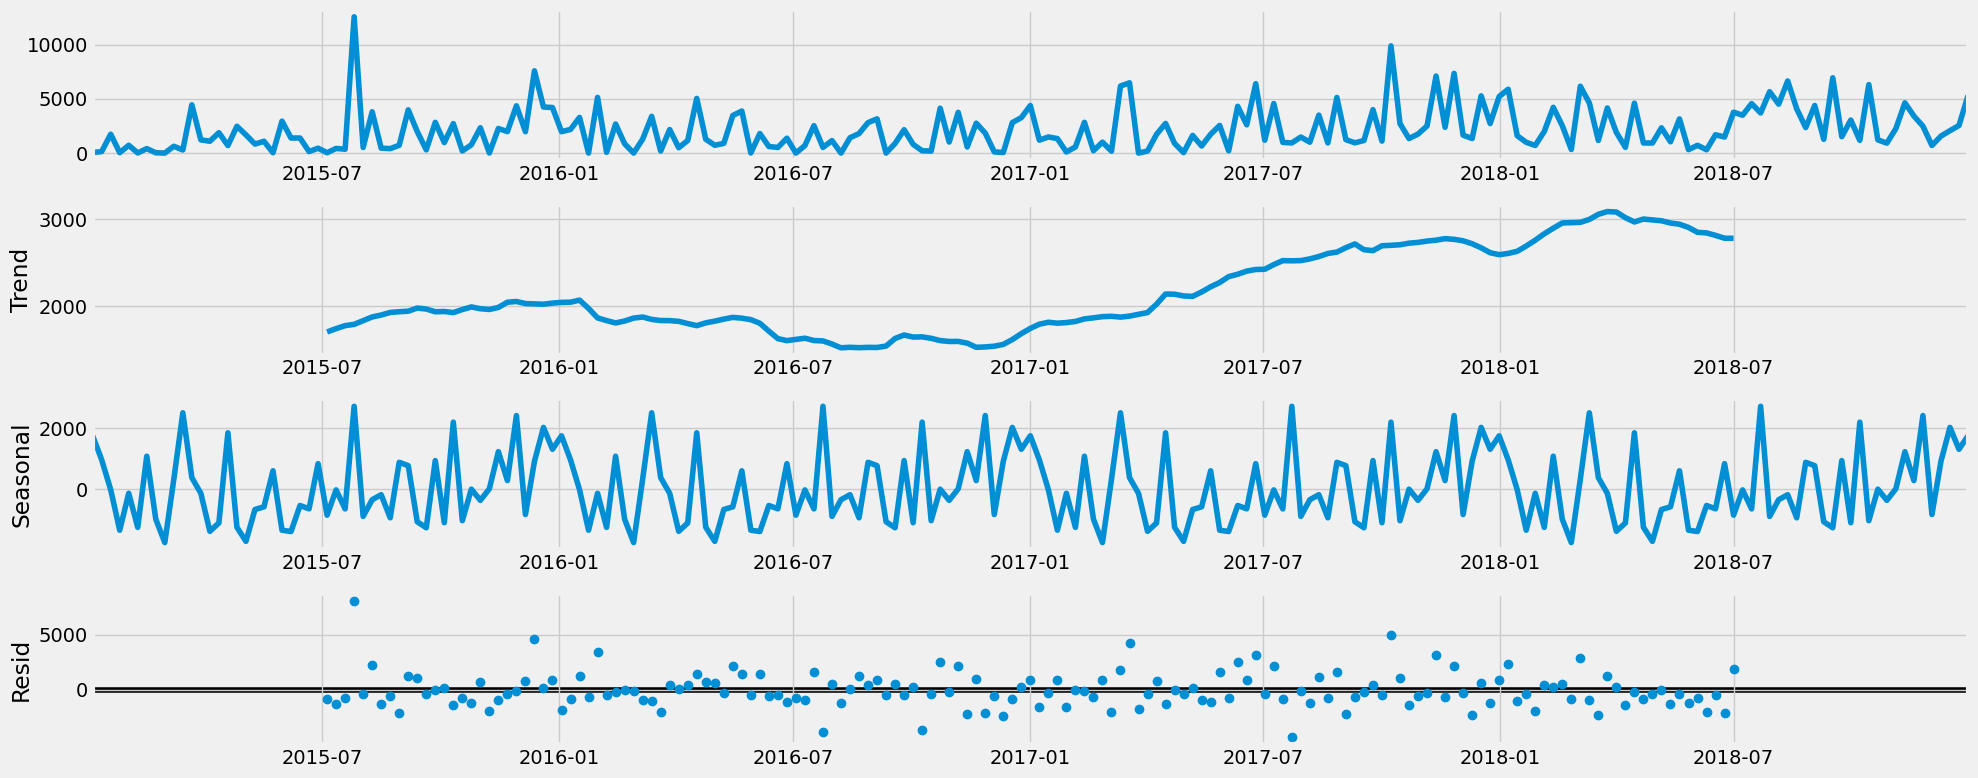

In [ ]:
## Califonia Weekly Sales Decomposition: (Seasonality - Trend - Noise)
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(California[['sales']])
fig = decomposition.plot()
plt.show()

## **5. Modeling & Evaluation**

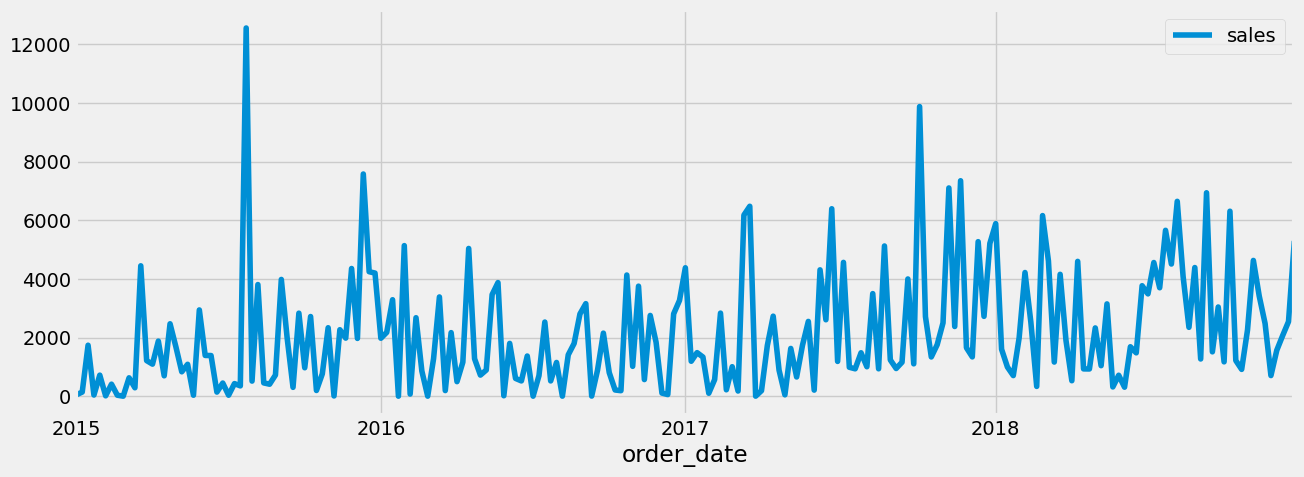

The data is stationary (i.e. it has no significant trends)


In [ ]:
## checking the data stationarity

col = 'sales'
fig, ax = plt.subplots(figsize=(14, 5)); California.plot(ax=ax); plt.show();
result = adfuller(California[col])
if result[1] < 0.05:
  print('The data is stationary (i.e. it has no significant trends)')
  d=0
else: print('The data is non-stationary (i.e. it has trends)')

In [ ]:
## fitting an optimized SARIMA model

results = pm.auto_arima(California,     ## data

                        d=d,            ## non-seasonal difference order
                        start_p=0,      ## initial guess for p
                        start_q=0,      ## initial guess for q
                        max_p=4,        ## max value of p to test
                        max_q=4,        ## max value of q to test

                        seasonal=False,  ## is the time series is seasonal
                        start_P=0,      ## initial guess for P
                        start_Q=0,      ## initial guess for Q
                        max_P=4,        ## max value of P to test
                        max_Q=4,        ## max value of Q to test

                        information_criterion='aic',   ## aic (more accurate) || bic (simpler)
                        trace=True,                    ## print results while training
                        error_action='ignore',         ## ignore orders that don't work
                        stepwise=True,                 ## apply intelligent efficient order search
                        suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3932.128, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3857.158, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3895.637, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3810.405, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3805.966, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=3800.972, Time=0.08 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=3776.307, Time=0.30 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3772.222, Time=0.62 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3773.611, Time=0.43 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.60 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3773.939, Time=0.38 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3775.170, Time=0.15 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0]          
Total fit time: 3.400 seconds


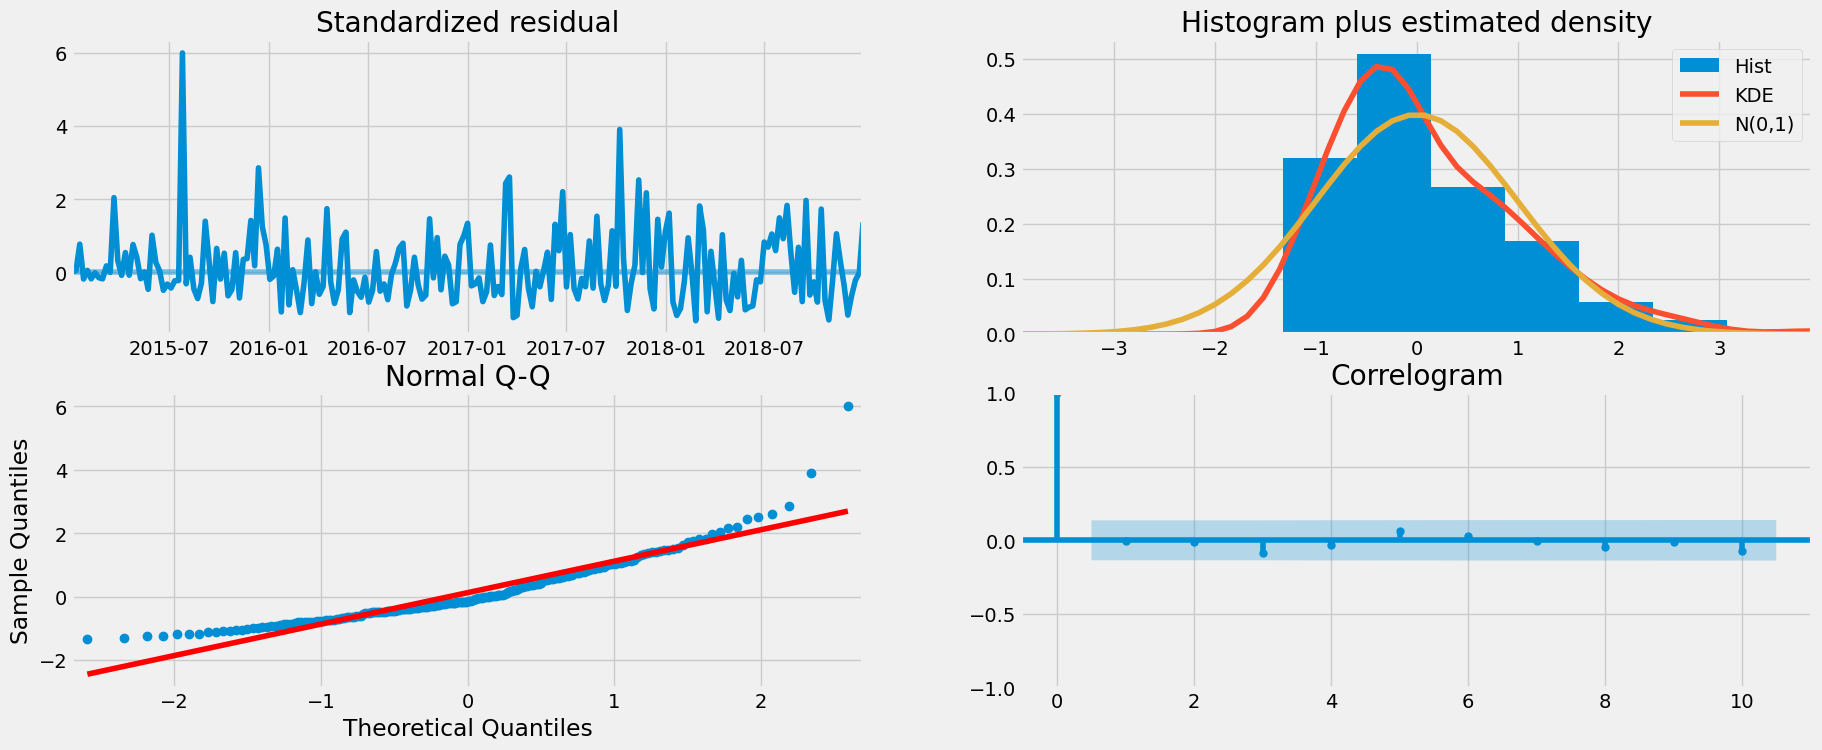

In [ ]:
## evaluation
results.plot_diagnostics()
plt.show()

## **6. Results**



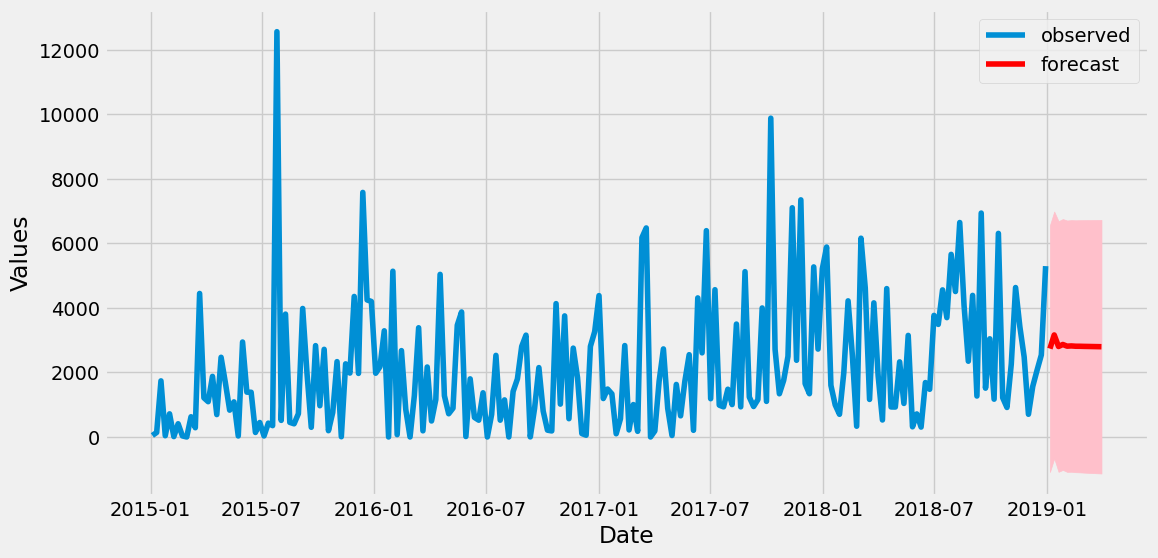

In [ ]:
## 3-month Forward Prediction
forecast = results.predict(n_periods=13, return_conf_int=True)

forecast_mean = forecast[0]

forecast_confidence = forecast[1]
lower_limits = forecast_confidence[:, 0]
upper_limits = forecast_confidence[:, 1]

plt.figure(figsize=(12, 6))
plt.plot(California.index, California, label='observed')
plt.plot(forecast_mean.index, forecast_mean, color='r', label='forecast')
plt.fill_between(forecast_mean.index, lower_limits, upper_limits, color='pink')
plt.xlabel('Date'); plt.ylabel('Values'); plt.legend(); plt.show();

## **7. Conclusion:**

> Having applied **ARIMA** on **California stores data**, we managed to provide the stores management with the insights they need.

(i.e. 3 months of sales forecasts)


## **Author**

- <a href="https://www.linkedin.com/in/ayman-altaweel" target="_blank">Ayman Altaweel - LinkedIn</a>

- <a href="https://github.com/Ayman947?tab=repositories" target="_blank">Ayman Altaweel - Github</a>
